In [5]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim
import control as ct
import scipy.linalg as scplin

In [ ]:
# generate reference trajectory

# Noises
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

dt = 0.01
x0 = np.zeros((mf.STATE_LEN, 1))
xf = np.zeros((mf.STATE_LEN, 1))
xf2 = np.zeros((mf.STATE_LEN, 1))
x0[:6] = np.array([[-1.57],[0],[1],[5],[0],[-0.5]])
xf[:6] = np.array([[0],[0],[6],[1],[0.1],[0]])
xf2[:6] = np.array([[1.57],[0],[8],[6],[0],[0.5]])
pos1, y_IMU1 = traj.gen_poly_traj(x0, xf, t0=0, tf=20, dt=dt)
pos2, y_IMU2 = traj.gen_poly_traj(xf, xf2, t0=0, tf=20, dt=dt)
pos = np.append(pos1[:,:-1], pos2, axis=1)
y_IMU = np.append(y_IMU1[:,:-1], y_IMU2, axis=1)
y_IMU = traj.gen_noise(y_IMU, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=np.array([[0.02],[0.7],[0.7]]))

xai = np.zeros((mf.STATE_LEN, 1)); xai[mf.X_P] = np.array([[6],[4]])
xaj = np.zeros((mf.STATE_LEN, 1)); xaj[mf.X_P] = np.array([[9],[6]])
pos_len = pos.shape[1]

# set noise sources: #0.000001, 0.00001, 0.00001
Q=np.diag([0.1, 8.0, 8.0, 1e-7, 1e-5, 1e-5])
R=np.diag([R_b, R_r, R_w, R_a, R_a]) # approx vaules from datasheets
P=np.diag([0,0,0,0,0,0,0,0,0.004,0.6,0.6]) # Initialize with system noise for bias

# Setup robots and anchors:
roboti = sim.Robot_single(x0=x0, path=pos, imu=y_IMU, dt=dt, Q=Q, R=R, P=P)
anchori = sim.Anchor(x0=xai)
anchorj = sim.Anchor(x0=xaj)

# Setup innovation:
inno_log = np.zeros((3,pos.shape[1]))
inno_pos = np.zeros((2, 0))

# Run algorithm:
for i in range(pos_len-1):
    inno_log[:,i:i+1] = roboti.predict()
    if 0: #(i % 100 == 0):
        inno_small = roboti.anchor_meas(anchori, ax=None, sr=R_r, sb=R_b)
        inno_pos = np.append(inno_pos, inno_small, axis=1)
    if (i % 100 == 0):
        inno_small = roboti.anchor_meas(anchorj, ax=None, sr=R_r, sb=R_b)
        inno_pos = np.append(inno_pos, inno_small, axis=1)

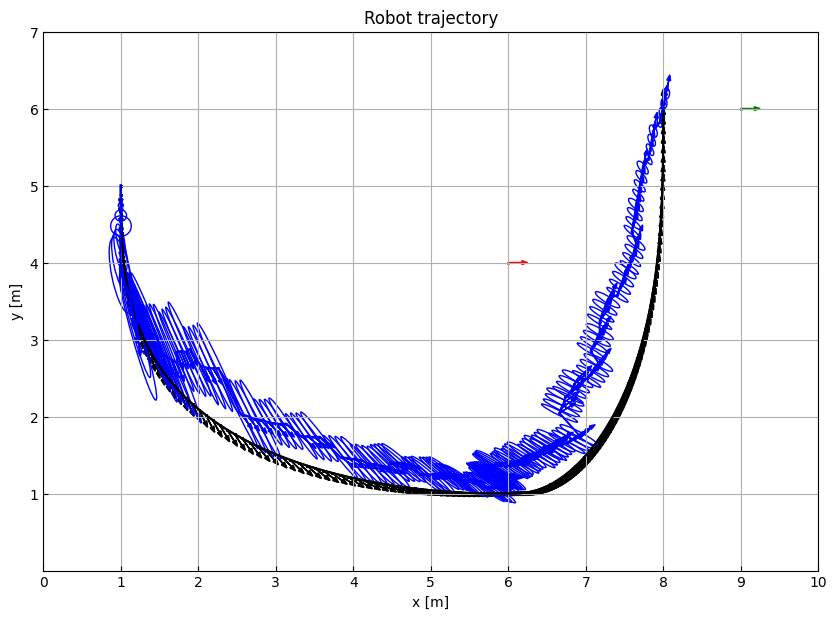

In [25]:
# Plotting

# Setup plot:
fig, ax = rp.setup_plot(figsize=(10,7), x=[0, 10], y=[0,7])
rp.plot_position(ax, pos[:,::25], color='black')
anchori.draw_position(ax, color='red')
anchorj.draw_position(ax, color='green')

x_log = roboti.x_log
P_log = roboti.P_log

rp.plot_position(ax, pos[:,::25], color='black')
rp.plot_position2(ax, x_log[:,::25], P_log[:,:,::25], color='blue')

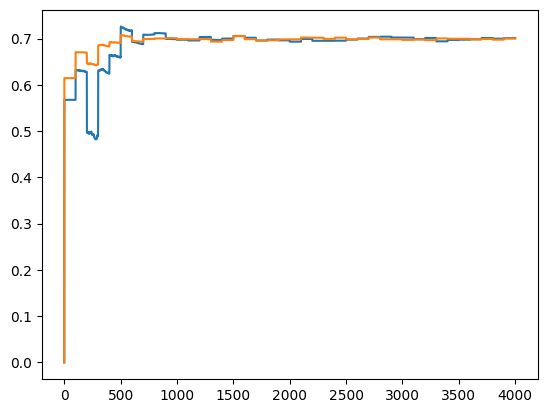

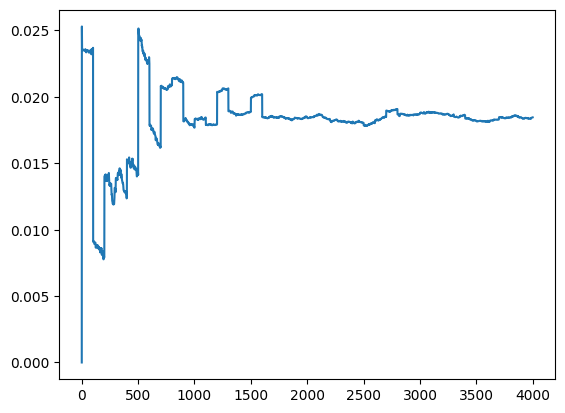

In [21]:
# Plot the bias states:
x_log = roboti.x_log
# For acc:
plt.figure()
plt.plot(x_log[9,:])
plt.plot(x_log[10,:])
plt.figure()
plt.plot(x_log[8,:])

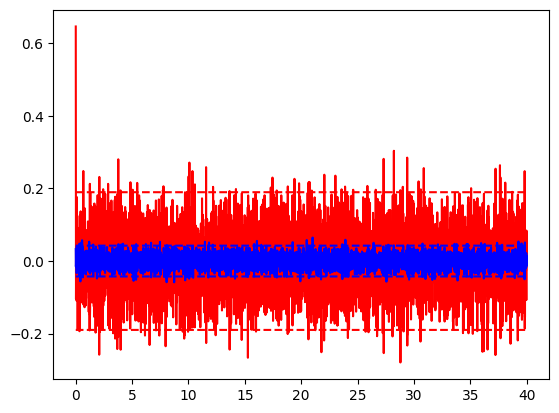

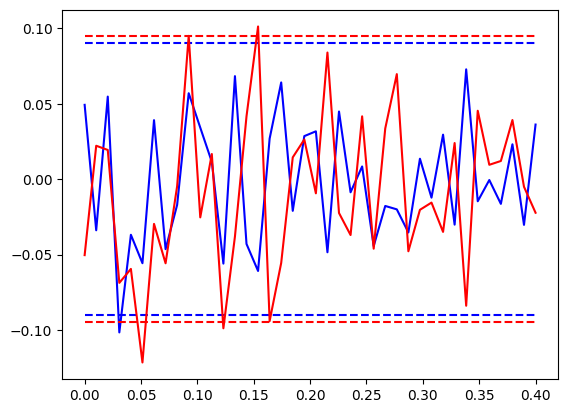

In [22]:
# Plot the innovation process of IMU:
fig, ax2 = plt.subplots()
rp.plot_innovation(ax2, inno_log[1,:], R_a, dt=dt, color='red')
rp.plot_innovation(ax2, inno_log[0,:], R_w, dt=dt)
fig, ax3 = plt.subplots()
rp.plot_innovation(ax3, inno_pos[0,:], R_b, dt=dt)
rp.plot_innovation(ax3, inno_pos[1,:], R_r, dt=dt, color='red')

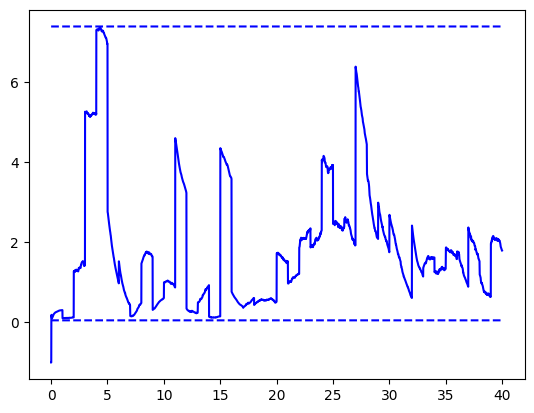

In [23]:
# NEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, ax4 = plt.subplots()
rp.plot_NEES(ax4, 
             x_est=roboti.x_log[mf.X_P,:],
             x_true=roboti.path[1:3,:], 
             P=roboti.P_log[mf.X_P, mf.X_P,:], 
             dt=dt,
             prob=0.95)

In [6]:
# Obsevability analysis
"""
H_obs = roboti.meas.get_jacobian_full(x0, xf2, roboti.t)

A_obs = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Om = ct.obsv(A_obs, H_obs)
print('full system')
print(np.linalg.matrix_rank(Om))

print(A_obs.shape[0])

nullM = scplin.null_space(Om)
print(nullM)

eigA, EigVA = np.linalg.eig(A_obs)
print(eigA)
print(EigVA)
"""


"\nH_obs = roboti.meas.get_jacobian_full(x0, xf2, roboti.t)\n\nA_obs = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n                  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],\n                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],\n                  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],\n                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],\n                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])\n\nOm = ct.obsv(A_obs, H_obs)\nprint('full system')\nprint(np.linalg.matrix_rank(Om))\n\nprint(A_obs.shape[0])\n\nnullM = scplin.null_space(Om)\nprint(nullM)\n\neigA, EigVA = np.linalg.eig(A_obs)\nprint(eigA)\nprint(EigVA)\n"